In [111]:
# %matplotlib notebook
%matplotlib inline
import pandas as pd, numpy as np, matplotlib.pyplot as plt, calendar
import os
import seaborn as sns; sns.set(style="ticks", color_codes=True)

# For a bit more data exploration
from sklearn.tree import DecisionTreeRegressor # Import Decision Tree Regressor
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

# import seaborn as sns

## Introduction

The aim of this notebook is to generate data matrices including potential features of use in predicting lake chemistry and ecology in Lake Vansjø. Data is read in for the River Hobøl and Lake Vansjø in the Morsa vannområde. Data includes meteorological data, NVE discharge data, river chemistry data and lake chemistry and ecology data for the period ca. 1980-2017/8. Data is cleaned and aligned, and then seasonal averages or sums are calculated and associated derived features (e.g. lags, winter sums).

Exploratory data analysis is then undertaken, including exploration of correlation coefficients and some graphs. Data matrices for each of the four target variables (lake TP concentration, chl-a concentration, biovolume of cyanobacteria and colour) are written to csv for use elsewhere.

This notebook builds on notebook 01_Make_data_matrix.ipynb, where the aim was monthly rather than seasonal aggregation of the data. Notebook 01 contains some more exploration of the daily data and explanations for some of the data cleaning choices made.

Created by Leah JB. Part of the ERA4CS WATExR project.

## Read in data

In [112]:
# User input
# Which Vansjø basin? Van1 (Storefjorden), Van2 (Vanemfjorden)
basin = 'Van2'

# Include TP flux estimates in the data matrix?
inc_fluxes = 0 # 0 or 1

# Include features from Van1 in Van2's features? Only relevant if basin is Van2
inc_Van1 = 0

# FILE PATHS to input data

# Met (T, pptn)
met_fpath = r'../data/Daily_1km_gridded_data_Morsa.csv'
wind_fpath = r'../data/Obs_Rygge_MeanWindSpeed.csv' # Mean daily wind speed (m/s), Rygge airport
PET_fpath = r'../data/Morsa_ThornthwaitePET.csv' #N.B. calculated using met station temp rather than gridded. But the two are v. comparable (not so pptn)

# Discharge
Q_fpath = r'../data/3-22-0_D6pm_Hogfoss_Scaled_to_Kure.csv'

# Catchment water quality (at Kure)
catchwq_fpath = r'../data/003-59191_chem_obs.csv'

# Lake water quality
fname_dict = {'Van1':'Storefjorden (VAN1)', 'Van2':'Vanemfjorden (VAN2)'}
lakewq_fpath = r'../data/%s_chem_obs.csv'%fname_dict[basin]

# Alternative lake colour data (from Storefjorden, 20m depth, MOVAR data)
movar_color_fpath = r'../data/LakeColour_MOVAR.csv'

# Lake ecology (PTI, biovolume, cyanomax, cyano biovolume)
ecol_fpath = r'../data/%s_PTI_Cyano.xlsx'%basin

# Output folders
out_file = r'../data/DataMatrices'
graph_outfolder = r'../Figures/Scatterplots'

In [113]:
# READ IN
met_df = pd.read_csv(met_fpath, index_col=0, parse_dates=True, dayfirst=True)
pet_df = pd.read_csv(PET_fpath, index_col=0, parse_dates=True, dayfirst=True)
wind_df = pd.read_csv(wind_fpath, index_col=0, parse_dates=True, dayfirst=True)

Q_df = pd.read_csv(Q_fpath, index_col=0, parse_dates=True, dayfirst=True)

catchwq_df = pd.read_csv(catchwq_fpath, index_col=0, parse_dates=True, dayfirst=True)

lakewq_df = pd.read_csv(lakewq_fpath, index_col=0, parse_dates=True, dayfirst=True)
color_df = pd.read_csv(movar_color_fpath, index_col=0, parse_dates=True, dayfirst=True)

# If looking at Van2 (Vanemfjorden), also read in lake data from Storefjorden
if basin =='Van2' and inc_Van1==1:
    van1_fpath = r'../data/Storefjorden (VAN1)_chem_obs.csv'
    lakewq_df_van1 = pd.read_csv(van1_fpath, index_col=0, parse_dates=True, dayfirst=True)

# Read in ecol data from excel sheet one sheet at a time, then merge
PTI_df = pd.read_excel(ecol_fpath, sheet_name=0, index_col=3, parse_dates=True)
biovol_df = pd.read_excel(ecol_fpath, sheet_name=1, index_col=3, parse_dates=True)
cyanoBiovol_df = pd.read_excel(ecol_fpath, sheet_name=2, index_col=0, parse_dates=True)
ecol_df = pd.concat([PTI_df['PTI'], biovol_df['Biovolume_mm3_per_l'], cyanoBiovol_df['Cyano_biovol_mm3_per_l']], axis=1)

## Data cleaning and reorganising

For plots of data see notebook 01 (Make_data_matrix). That code is repeated here.

In [114]:
# MET DATA

# For the met data, just pick the columns of interest and rename them
met_df = met_df[['RR','TG']]
met_df.columns = ['Pptn','Temp']
met_df.index.name = 'Date'

# Add mean daily wind speed (m/s)
met_df['Wind_speed'] = wind_df.iloc[:,0]

# Also add PET (mm/day)
met_df['PET'] = pet_df['PET']

# Q DATA
Q_df = Q_df['Q_18H_average_m3s_scaled']
Q_df.rename('Q', inplace=True)

# Lake colour data (merge MOVAR and NIVA data). Before Jan 1999: NIVA data, Jan 1999- end 2012: Movar data, from Jan 2013: NIVA data
lakewq_df = pd.merge(lakewq_df, color_df, left_index=True, right_index=True, how='outer')

# Before Jan 1999: NIVA data, Jan 1999- end 2012: Movar data, from Jan 2013: NIVA data
s0 = lakewq_df.loc[:'1998-12-31','colour']

id1 = lakewq_df['Colour'].first_valid_index()
s1 = lakewq_df['Colour'].loc[id1:]
s1.name = 'colour'

lastidx = lakewq_df.loc['2013-01-01':,'colour'].last_valid_index()
s2 = lakewq_df.loc['2013-01-01':lastidx,'colour']

colour = pd.concat([s0, s1,s2], axis=0).dropna()

# Drop original MOVAR and NIVA colour series, and replace with the patched series
lakewq_df = lakewq_df.drop(['colour','Colour'], axis=1)
lakewq_df = lakewq_df.merge(colour.to_frame(), left_index=True, right_index=True, how='outer')

# Drop some dodgy-looking values
lakewq_df.loc[:'1982-08-01','colour'] = np.NaN
lakewq_df[lakewq_df[['SS','SS_min']]>25.] = np.NaN
met_df.loc[met_df['Pptn']<0.,'Pptn'] = 0.

if basin == 'Van2' and inc_Van1==1:
    lakewq_df_van1.loc[:'1982-08-01','colour'] = np.NaN

## Combine data and derive variables

['Pptn' 'Temp' 'Wind_speed' 'PET' 'Q' 'TP_catch' 'chl-a_lake' 'TP_lake'
 'colour_lake' 'PTI' 'Biovolume' 'CyanoBiovol']


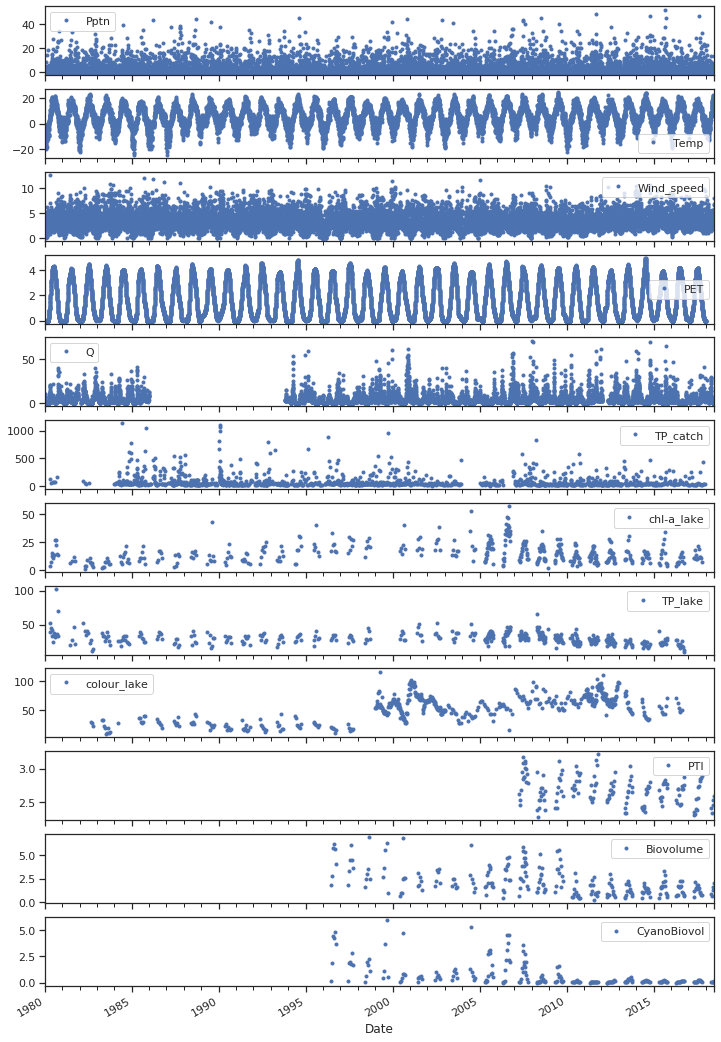

In [115]:
# Add suffixes to lake and water quality columns
catchwq_df = catchwq_df.add_suffix('_catch')
lakewq_df = lakewq_df.add_suffix('_lake')

if basin == 'Van2' and inc_Van1==1:
    lakewq_df_van1 = lakewq_df_van1.add_suffix('_van1')

# REINDEX & JOIN ALL DATASETS INTO ONE DATAFRAME

if basin == 'Van2' and inc_Van1==1:
    df_list = [met_df, Q_df, catchwq_df, lakewq_df, ecol_df, lakewq_df_van1]
else:
    df_list = [met_df, Q_df, catchwq_df, lakewq_df, ecol_df]

for i, df in enumerate(df_list):
    df = df.reindex(index=met_df.index)
    if i<1:
        daily_df = df
    else:
        daily_df = daily_df.join(df)

# Remove data pre-1980
daily_df = daily_df.loc['1980-01-01':,:]

# Drop some cols and rename others
if basin == 'Van2' and inc_Van1==1:
    cols_to_drop = ['SS_min_catch', 'SS_catch','TDP_catch','SRP_catch',
                    'TOC_lake','TDP_lake','SS_lake','SS_min_lake',
                    'TOC_van1', 'TDP_van1', 'SS_min_van1', 'SS_van1',]
else:
    cols_to_drop = ['SS_min_catch', 'SS_catch','TDP_catch','SRP_catch',
                    'TOC_lake','TDP_lake','SS_lake','SS_min_lake']
    
var_rename_dict = {'Biovolume_mm3_per_l':'Biovolume','Cyano_biovol_mm3_per_l':'CyanoBiovol'}

daily_df.drop(cols_to_drop, axis=1, inplace=True)
daily_df.rename(var_rename_dict, axis=1, inplace=True)

# Check output
print(daily_df.columns.values)
daily_fig = daily_df.loc['1980-01-01':,:].plot(subplots=True, style='o', ms=3, figsize=(12,20));

# plt.savefig(os.path.join(graph_outfolder,'daily_data_tseries.png'))


### Precipitation-related features

                Pptn  Rain_day
Date                          
1980-01-01  0.000000         0
1980-01-02  0.000000         0
1980-01-03  0.000000         0
1980-01-04  2.693679         1
1980-01-05  3.016553         1
8.464601579400002
                Pptn  Pptn_intense
Date                              
1980-01-01  0.000000             0
1980-01-02  0.000000             0
1980-01-03  0.000000             0
1980-01-04  2.693679             0
1980-01-05  3.016553             0


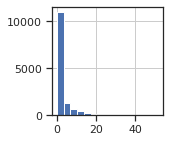

In [116]:
# Add derived variables from daily data.
# Don't bother with residence time or fluxes as didn't seem important in monthly analysis, and for fluxes lots of missing vaules

# Precipitation features:
# (1) rain day (boolean of whether it rained that day or not)
def rain_day(pptn):
    if pptn>0.: return 1
    else: return 0
daily_df['Rain_day'] = daily_df['Pptn'].map(rain_day)
print (daily_df[['Pptn','Rain_day']].head())

# (2) pptn intensity: Boolean saying whether precipitation is above a certain threshold
# First, take a look at the distribution of rainfall to decide on the threshold
daily_df['Pptn'].hist(bins=15, figsize=(2,2))
print (daily_df['Pptn'].quantile(q=0.90))

# Decide to use threshold of 90th percentile, 8.2 mm/day
def rain_intense(pptn):
    if pptn>8.2: return 1
    else: return 0
daily_df['Pptn_intense'] = daily_df['Pptn'].map(rain_intense)
print (daily_df[['Pptn','Pptn_intense']].head())

### Wind speed-related features

Nothing wind-related really came out as important in the monthly analysis. So here, cut down on the number of wind-related features to include. Also just add in mean seasonal wind speed.

Median daily wind speed is 3.3 m/s, and the distribution is somewhat right skewed. The main thing that is likely to be important for cyanobacteria is a stable upper water column, so that turbulence doesn't cause cells to sink. The duration of the stable upper water column could also be important, so features could be e.g. x days below whatever wind speed threshold is required for a stable upper water column, AND no (potentially short-lived) periods where the water column is mixed due to high winds.

Q0.2: 2.0 m/s
Q0.4: 2.9 m/s


Q0.6: 3.7 m/s
Q0.8: 4.8 m/s
            Wind_speed  Wind_under_Q0.2  Wind_over_Q0.6
Date                                                   
1980-01-01         2.9            False           False
1980-01-02         3.1            False           False
1980-01-03         1.5             True           False
1980-01-04         1.7             True           False
1980-01-05         1.5             True           False


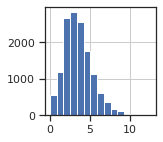

In [117]:
# Wind features: Boolean saying whether wind speed was above or below a certain threshold

# Distribution of wind speed
daily_df['Wind_speed'].hist(bins=15, figsize=(2,2))

# Define 'calm day' features
calm_quantiles = [0.2, 0.4] 
for quantile in calm_quantiles:
    upper_threshold = daily_df['Wind_speed'].quantile(quantile)
    print('Q%s: %s m/s' %(quantile, upper_threshold))
    daily_df['Wind_under_Q%s' %quantile] = daily_df['Wind_speed'] < upper_threshold

print('\n')
    
# Define 'windy day' features
windy_quantiles = [0.6, 0.8]
for quantile in windy_quantiles:
    lower_threshold = daily_df['Wind_speed'].quantile(quantile)
    print('Q%s: %s m/s' %(quantile, lower_threshold))
    daily_df['Wind_over_Q%s' %quantile] = daily_df['Wind_speed'] > lower_threshold
    
print (daily_df[['Wind_speed','Wind_under_Q0.2','Wind_over_Q0.6']].head())

### Temperature-related features

Later in the analysis I was finding that PET was coming out as a significant feature relating to biol. E.g. winter PET correlating with summer cyanobacterial biovolume. I think this could be more about ice thickness and duration, which I can't find long term records for. Instead, lets calculate winter freezing days (days where T<0), and assume the more subzero days the thicker the ice and the longer the ice duration.

In [118]:
daily_df['Temp_subzero'] = daily_df['Temp']<0.
daily_df[['Temp','Temp_subzero']].head()

,Temp,Temp_subzero
Date,,
1980-01-01,-6.478373,True
1980-01-02,-10.410182,True
1980-01-03,-15.997355,True
1980-01-04,-14.694798,True
1980-01-05,-5.953704,True


### Output daily data matrix

In [119]:
# Optionally output to csv
daily_df.to_csv(os.path.join(out_file,'Vansjø_daily_data_%s_fromNB03.csv' %basin), index_label='Date')

## Resample to seasonal

In [120]:
daily_df.columns

Index(['Pptn', 'Temp', 'Wind_speed', 'PET', 'Q', 'TP_catch', 'chl-a_lake',
       'TP_lake', 'colour_lake', 'PTI', 'Biovolume', 'CyanoBiovol', 'Rain_day',
       'Pptn_intense', 'Wind_under_Q0.2', 'Wind_under_Q0.4', 'Wind_over_Q0.6',
       'Wind_over_Q0.8', 'Temp_subzero'],
      dtype='object')

In [121]:
# Set the aggregation method for different variables

vars_to_sum = ['Pptn','Rain_day','Pptn_intense', 'PET',
              'Q', 'Temp_subzero']

# Add wind cols to vars to sum
wind_cols = []
for q in calm_quantiles:
    wind_cols.append('Wind_under_Q%s' %q)
for q in windy_quantiles:
    wind_cols.append('Wind_over_Q%s' %q)
vars_to_sum += wind_cols
    
vars_to_average = ['TP_catch',
                 'CyanoBiovol',
                 'PTI',
                 'Temp',
#                  'Q',
                 'Biovolume',
                 'rel_res_time',
                 'colour_lake',
                 'TP_lake',
                 'chl-a_lake',
                  'Wind_speed',
                  ]

if basin == 'Van2' and inc_Van1==1:
    vars_to_average.extend(['colour_van1','TP_van1','chl-a_van1'])

agg_method_dict = {} # Key: var, returns aggregation method
for var in daily_df.columns:
    if var in vars_to_sum:
        method = np.nansum
    elif var in vars_to_average:
        method = np.nanmean
    else:
        method = None
    agg_method_dict[var] = method

# agg_method_dict

In [122]:
# RESAMPLE TO SEASONAL

# Define 4 seasons per year. Lake sampling is from mid-April to mid-October, WFD status May-Sep. Split this into two (early summer and late summer)
# Value is returned next to the last day of the season

def season(x):
    """Input month number, and return the season it corresponds to
    """
    if x in [11,12,1]:
        return 'wint'
    if x in [2,3,4]:
        return 'spr'
    if x in [5,6,7]:
        return 'summ'
    if x in [8,9,10]:
        return 'aut'

# Resample (enter 'Q' for quarterly, and '-month' for month to end in)
# N.B. if you change season function, need to change this too
season_df = daily_df.resample('Q-Jan').agg(agg_method_dict)
season_df['Season'] = season_df.index.month.map(season)

# print (season_df.head(4))

# For Q, need to correct the units (summed up m3/s over days, convert to just m3 per season)
season_df['Q'] = season_df['Q'] * 86400.
# Also, summing over seasons gives 0 for Q due to no data. Replace with NaNs
season_df.loc[season_df['Q']==0.0,'Q'] = np.NaN

season_df.head(4)

,Pptn,Temp,Wind_speed,PET,Q,TP_catch,chl-a_lake,TP_lake,colour_lake,PTI,Biovolume,CyanoBiovol,Rain_day,Pptn_intense,Wind_under_Q0.2,Wind_under_Q0.4,Wind_over_Q0.6,Wind_over_Q0.8,Temp_subzero,Season
Date,,,,,,,,,,,,,,,,,,,,
1980-01-31,22.434315,-8.091381,2.319355,0.000000,6095174.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,1,14.0,17.0,6.0,2.0,31.0,wint
1980-04-30,80.992741,-2.933491,3.042222,38.550908,28217376.0,130.000000,3.971429,45.250000,NaN,NaN,NaN,NaN,45,2,26.0,37.0,27.0,9.0,59.0,spr
1980-07-31,242.199218,14.449403,3.101087,341.791701,30799440.0,68.333333,12.169127,36.084127,NaN,NaN,NaN,NaN,63,11,17.0,43.0,27.0,7.0,0.0,summ
1980-10-31,351.676639,9.575229,3.547826,185.500285,56804025.6,113.500000,20.773333,51.061905,NaN,NaN,NaN,NaN,81,14,17.0,38.0,33.0,20.0,7.0,aut


## Exploratory boxplots

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:355: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds


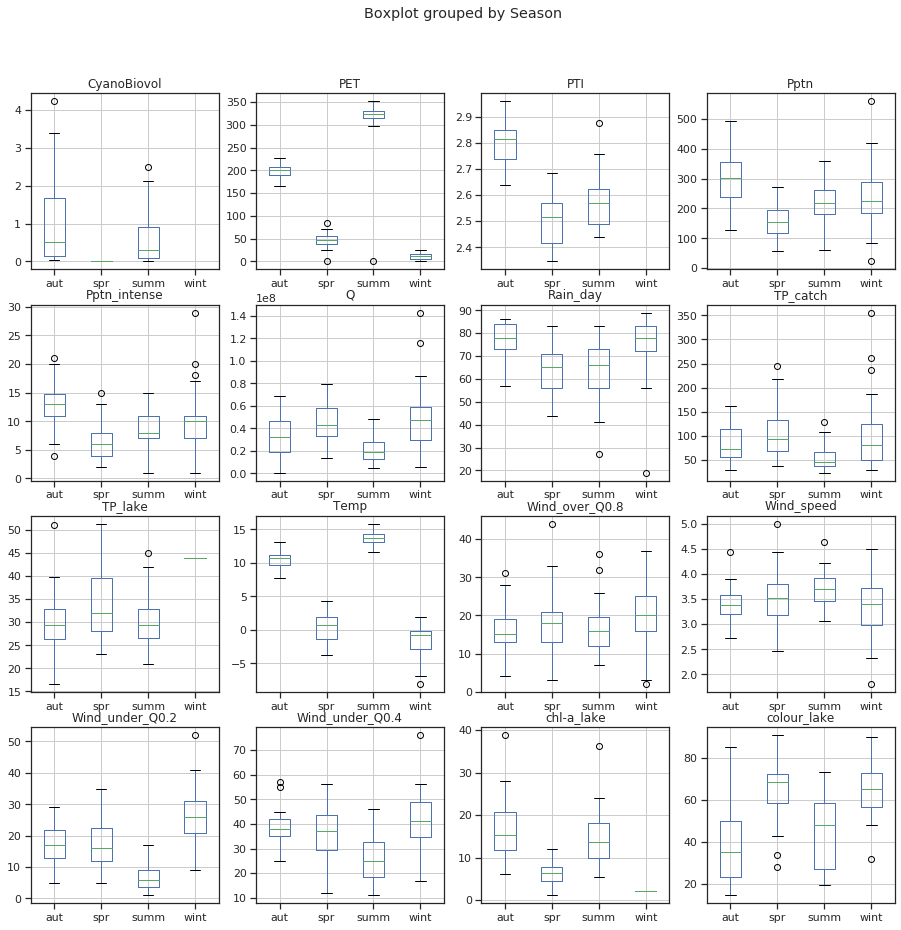

In [123]:
fig, axs = plt.subplots(4,4, sharey=False, figsize=(15,15))
bp = season_df.drop(['Biovolume','Wind_over_Q0.6','Temp_subzero'], axis=1).boxplot(by='Season', ax=axs);
[ax.set_xlabel('') for ax in bp];

plt.savefig(os.path.join(graph_outfolder, 'Season_boxplots.png'))

## Add lagged variables

In [124]:
# For desired variables, add 1 (and optionally a 2 season) lag

# Only do for variables that we will have data for or may be able to estimate
lag_vars = ['Pptn', 'Temp', 'Wind_speed', 'PET', 'Q', 'chl-a_lake',
           'TP_lake', 'colour_lake', 'CyanoBiovol',
           'Rain_day', 'Pptn_intense',
           'Wind_under_Q0.2', 'Wind_under_Q0.4', 'Wind_over_Q0.6',
           'Wind_over_Q0.8'],

for var in season_df.columns:
    season_df['%s_lag1' %var] = season_df[var].shift(+1)
#     season_df['%s_lag2' %var] = season_df[var].shift(+2)

    
season_df[['Pptn','Pptn_lag1']].head()

,Pptn,Pptn_lag1
Date,,
1980-01-31,22.434315,NaN
1980-04-30,80.992741,22.434315
1980-07-31,242.199218,80.992741
1980-10-31,351.676639,242.199218
1981-01-31,138.440254,351.676639


In [125]:
# For all variables that are summed on aggregating, calculate the sum for the
# previous winter (October - March)

# First, add a 'season_2' column, splitting data into 'winter' (Oct-March) and 'summer' (Apr-Sep)
# N.B. October lake sampling in 'winter' then
def growing_season(season):
    if season in ['wint','spr']:
        return 0
    else:
        return 1
season_df['season_summ'] = season_df['Season'].map(growing_season)


# Then filter to just winter and calculate winter sums per year
wint_sum_df = season_df.loc[season_df['season_summ']==0, vars_to_sum]
                  
yr_li = []
for yr in range(1980,2019):
    a = 2*[yr]
    yr_li.extend(a)
wint_sum_df['sum_yr'] = yr_li

# Group by years and work out number of months with obs (for filtering
# out years where don't have enough months with obs). And sum!
wint_sum_df_counts = wint_sum_df.groupby('sum_yr').count()
wint_sum_df = wint_sum_df.groupby('sum_yr').sum()

# 1980 doesn't have a complete year, so drop from the winter sum calcs
wint_sum_df.loc[1980,:] = np.NaN

for var in vars_to_sum:
    season_df['%s_winterSum' %var] = season_df[var].index.year.map(lambda x: wint_sum_df.loc[x,var])
    
# There are years with missing data in the Q series. These values return 0 for the winter discharge sum.
# Replace with NaNs

season_df.loc[season_df['Q_winterSum']==0.0,'Q_winterSum'] = np.NaN

season_df.loc['1980':'1985',['Rain_day','Rain_day_winterSum', 'Temp_subzero_winterSum', 'Q_winterSum']]



,Rain_day,Rain_day_winterSum,Temp_subzero_winterSum,Q_winterSum
Date,,,,
1980-01-31,19,NaN,NaN,NaN
1980-04-30,45,NaN,NaN,NaN
1980-07-31,63,NaN,NaN,NaN
1980-10-31,81,NaN,NaN,NaN
1981-01-31,58,102.0,116.0,69390950.4
1981-04-30,44,102.0,116.0,69390950.4
1981-07-31,69,102.0,116.0,69390950.4
1981-10-31,72,102.0,116.0,69390950.4
1982-01-31,56,105.0,106.0,96553900.8


In [126]:
# Add maximum for previous summer for ecol variables. All these vars have a summer peak.
# N.B. assumes no outliers.

# prev_summ_vars = ['chl-a_lake', 'CyanoBiovol']

# annual_max_df = daily_df.groupby(daily_df.index.year).max()
# annual_max_df = annual_max_df[prev_summ_vars]
# for var in annual_max_df.columns:
#     annual_max_df['%s_prevSummer' %var] = annual_max_df[var].shift(+1)

# print(annual_max_df.tail())

# for var in prev_summ_vars:
#     season_df['%s_prevSummer' %var] = season_df[var].index.year.map(lambda x: annual_max_df.loc[x,'%s_prevSummer' %var])

# season_df.loc['2017':'2018',['CyanoBiovol','CyanoBiovol_prevSummer']]

In [127]:
# For lake TP conc and colour, calculate summer average (mean of early and late summer seasons) from previous year rather than max (as at its max during winter and spring)

# prev_summer_toaverage = ['TP_lake', 'colour_lake']
prev_summer_toaverage = ['TP_lake', 'colour_lake', 'chl-a_lake', 'CyanoBiovol']


# Filter to just summer and average per year
summer_av_df = season_df.loc[season_df['season_summ']==1, prev_summer_toaverage]
print(summer_av_df.head())
summer_av_df = summer_av_df.groupby(summer_av_df.index.year).mean()

# Shift by a year
for var in summer_av_df.columns:
    summer_av_df['%s_prevSummer' %var] = summer_av_df[var].shift(+1)
print(summer_av_df.head())

for var in prev_summer_toaverage:
    season_df['%s_prevSummer' %var] = season_df[var].index.year.map(lambda x: summer_av_df.loc[x,'%s_prevSummer' %var])

season_df.loc['1980':'1981',['TP_lake','TP_lake_prevSummer']]

              TP_lake  colour_lake  chl-a_lake  CyanoBiovol
Date                                                       
1980-07-31  36.084127          NaN   12.169127          NaN
1980-10-31  51.061905          NaN   20.773333          NaN
1981-07-31  23.583333          NaN    7.075000          NaN
1981-10-31  34.083333          NaN    9.587500          NaN
1982-07-31  37.777778          NaN    5.466667          NaN
        TP_lake  colour_lake  chl-a_lake  CyanoBiovol  TP_lake_prevSummer  \
Date                                                                        
1980  43.573016          NaN   16.471230          NaN                 NaN   
1981  28.833333          NaN    8.331250          NaN           43.573016   
1982  28.336806    26.666667    5.847917          NaN           28.833333   
1983  29.055000    17.033333    6.073333          NaN           28.336806   
1984  26.527500          NaN   11.090000          NaN           29.055000   

      colour_lake_prevSummer  chl-a_lake

,TP_lake,TP_lake_prevSummer
Date,,
1980-01-31,NaN,NaN
1980-04-30,45.250000,NaN
1980-07-31,36.084127,NaN
1980-10-31,51.061905,NaN
1981-01-31,NaN,43.573016
1981-04-30,NaN,43.573016
1981-07-31,23.583333,43.573016
1981-10-31,34.083333,43.573016


In [128]:
print (len(season_df.columns))
season_df = season_df.drop(['Season_lag1','season_summ'], axis=1)
# sorted(season_df.columns)

55


### Output seasonal data matrix

In [129]:
# output to csv
season_df.to_csv(os.path.join(out_file,'Vansjø_seasonal_data_%s.csv' %basin))

## Split into separate matrices for the 4 possible response variables

First, decide whether want to keep all seasons, or just look at one season

In [130]:
season_slice = 'summ' # one of 'all', 'wint', 'spr','summ','aut'

print(len(season_df))

if season_slice in ['wint', 'spr','summ','aut']:
    season_df = season_df.loc[season_df['Season']==season_slice, :]

print(len(season_df))

155
39


In [131]:
# sorted(season_df.columns)

In [132]:
# First, lake TP concentration is the explanatory variable.
cols_to_drop = [
 'Biovolume',
 'Biovolume_lag1',
 'CyanoBiovol',
 'CyanoBiovol_lag1',
 'CyanoBiovol_prevSummer',
 'PTI',
 'PTI_lag1',
 'chl-a_lake',
 'chl-a_lake_lag1',
 'chl-a_lake_prevSummer',
 'colour_lake',
 'colour_lake_lag1',
 'colour_lake_prevSummer',
 'Temp_subzero'
    ]

season_df_TP = season_df.drop(cols_to_drop,axis=1)
print (len(season_df_TP))

# Drop any rows where TP_lake is a NaN
season_df_TP.dropna(subset=['TP_lake'], inplace=True)
print (len(season_df_TP))
season_df_TP.head()

39
36


,Pptn,Temp,Wind_speed,PET,Q,TP_catch,TP_lake,Rain_day,Pptn_intense,Wind_under_Q0.2,...,Rain_day_winterSum,Pptn_intense_winterSum,PET_winterSum,Q_winterSum,Temp_subzero_winterSum,Wind_under_Q0.2_winterSum,Wind_under_Q0.4_winterSum,Wind_over_Q0.6_winterSum,Wind_over_Q0.8_winterSum,TP_lake_prevSummer
Date,,,,,,,,,,,,,,,,,,,,,
1980-07-31,242.199218,14.449403,3.101087,341.791701,30799440.0,68.333333,36.084127,63,11,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-07-31,282.257779,13.213264,3.836957,320.174316,37862640.0,NaN,23.583333,69,11,7.0,...,102.0,10.0,38.634388,69390950.4,116.0,40.0,67.0,71.0,38.0,43.573016
1982-07-31,151.006233,13.452291,3.691304,318.228851,18691344.0,45.500000,37.777778,47,7,9.0,...,105.0,14.0,50.619540,96553900.8,106.0,47.0,81.0,72.0,42.0,28.833333
1983-07-31,182.728817,13.517998,4.078261,320.759861,20778336.0,NaN,31.960000,63,7,5.0,...,121.0,18.0,62.161543,124071782.4,71.0,43.0,72.0,86.0,48.0,28.336806
1984-07-31,255.820629,13.845605,4.044565,329.067020,14499561.6,128.100000,27.360000,57,12,4.0,...,121.0,5.0,47.655810,73802188.8,107.0,36.0,65.0,94.0,58.0,29.055000


In [133]:
# Take a look at what's missing
# First, drop any columns which don't have NaNs, then plot
# monthly_df_lakeTP.loc[:, monthly_df_lakeTP.isna().any()].plot(subplots=True, figsize=(12,30))

In [134]:
X = season_df_TP.drop(['TP_lake'],axis=1)
y = season_df_TP['TP_lake']
corr_df = X.corrwith(y)
corr_df.sort_values()

Wind_over_Q0.6_winterSum    -0.302842
Wind_over_Q0.8_winterSum    -0.241597
PET_lag1                    -0.198101
Wind_speed_lag1             -0.163222
Temp_lag1                   -0.159345
Rain_day                    -0.158299
Pptn_intense_lag1           -0.155134
PET_winterSum               -0.104210
Wind_over_Q0.8_lag1         -0.098992
Q_lag1                      -0.088626
Wind_speed                  -0.080210
TP_catch                    -0.073080
Wind_over_Q0.6_lag1         -0.070706
Wind_over_Q0.8              -0.058033
Pptn                        -0.046319
Wind_over_Q0.6              -0.018046
Q                           -0.007740
Pptn_lag1                    0.026564
Temp_subzero_winterSum       0.055302
Pptn_intense                 0.063437
Wind_under_Q0.4              0.063767
Wind_under_Q0.4_lag1         0.109061
Rain_day_lag1                0.121576
Q_winterSum                  0.127470
Temp                         0.144676
Temp_subzero_lag1            0.151090
Rain_day_win

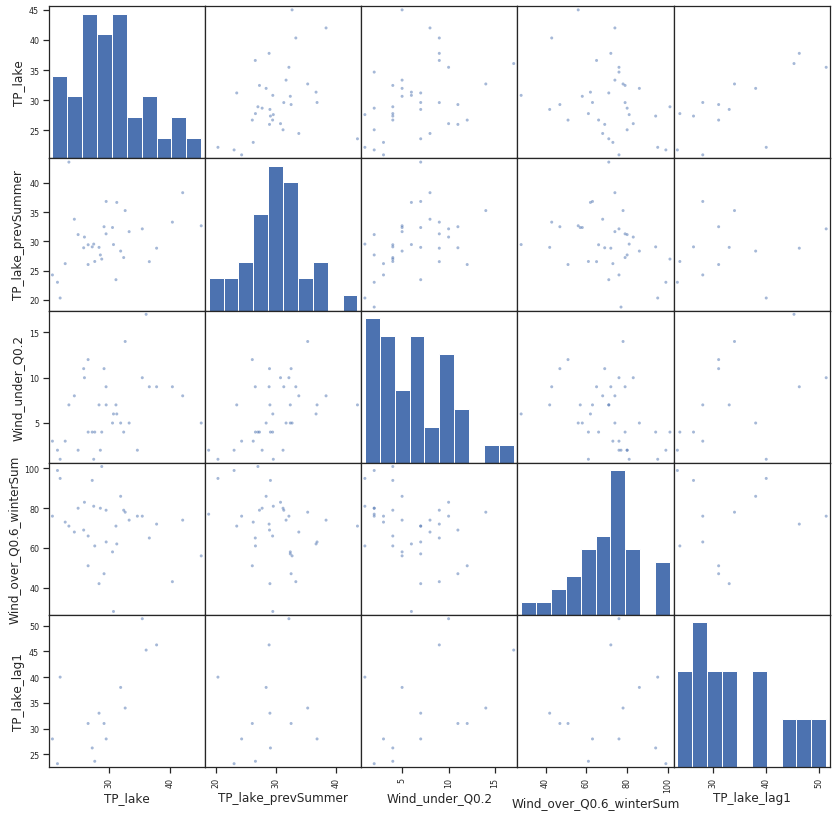

In [135]:
vars_for_scatterplot = ['TP_lake','TP_lake_prevSummer', 'Wind_under_Q0.2', 'Wind_over_Q0.6_winterSum',
                       'TP_lake_lag1']

pd.plotting.scatter_matrix(season_df.loc[:,vars_for_scatterplot], figsize=(14,14));

plt.savefig(os.path.join(graph_outfolder,'seasonal_scattermatrix_TP_%s_%s.png'%(season_slice,basin)))

**Van2 (Vanemfjorden), Comments:**

All seasons together:
- As with monthly data, the best potential explanatory variables are lake TP concentration from the previous season, then the previous summer (CCs 0.38, 0.33)
- Possible wind effect too: as with monthly data, the calmer the previous winter, the higher the TP (CCs 0.35 and lower. Highest CC (-0.35) for wind days > Q0.8). Still don't know what's going on here/what the mechanism is... Less wind -> more TP, i.e. it's not resuspension (that would be more wind -> more TP). Could be related to mixing of the water column? i.e. less wind, have more TP accumulation at the surface? Or something to do with ice cover because of the stronger winter effect. Or perhaps windy winter weather is accompanied by big storms and rain, and higher inputs, but then you'd expect precipitation metrics and Q to be more important...
- Temp effect a bit more apparent than with monthly data: CC -0.26 (i.e. warmer means lower TP)
- Everything else weaker.
- No link to air T seen, unlike Storefjorden. Because it's shallower, so don't get such stratification?
- No relation with met variables relating to delivery. Suggesting internal processing and P sources are more important?

**Just early summer (May-Jul):**
- Super strong correlation with spring TP (CC 0.70). Rest of the CCs all under 0.34
- Wind vars come in next:
        Current season - wind days under Q0.2 (CC 0.34). i.e. calmer gives higher TP
        Winter wind - wind days over Q0.6 (CC -0.34), i.e. windier winter gives lower TP/calmer winter gives higher TP
- Lake TP previous summer (CC 0.33)

**Just late summer (Aug-Oct):**
- TP_lake_prevSummer (0.56)
- Wind vars: very similar to early summer.
        Early summer wind: days under Q0.2 (CC 0.36)
        Winter windy days over Q0.8 (CC-0.42) or Q0.6 (-0.4).

### 2) Response var = Lake chl-a concentration

In [136]:
# 2) chl-a concentration
cols_to_drop = [
 'Biovolume',
 'Biovolume_lag1',
 'CyanoBiovol',
 'CyanoBiovol_lag1',
 'CyanoBiovol_prevSummer',
 'PTI',
 'PTI_lag1',
 'Temp_subzero'
    ]

season_df_lake_chla = season_df.drop(cols_to_drop,axis=1)
print (len(season_df_lake_chla))

# Drop any rows where explanatory variable value is a NaN
season_df_lake_chla.dropna(subset=['chl-a_lake'], inplace=True)
print (len(season_df_lake_chla))
# monthly_df_lake_chla.head()

39
37


In [137]:
X = season_df_lake_chla.drop(['chl-a_lake'],axis=1)
y = season_df_lake_chla['chl-a_lake']
corr_df = X.corrwith(y)
corr_df.sort_values()

Wind_over_Q0.6_winterSum    -0.479676
Wind_over_Q0.8_winterSum    -0.456460
Wind_over_Q0.8              -0.313222
Wind_speed                  -0.243594
TP_lake_lag1                -0.191925
Wind_over_Q0.6              -0.190617
Q_lag1                      -0.185368
Wind_over_Q0.6_lag1         -0.169473
Wind_over_Q0.8_lag1         -0.166058
Wind_speed_lag1             -0.145338
TP_catch_lag1               -0.124986
Q                           -0.120358
Q_winterSum                 -0.069946
Temp_subzero_winterSum      -0.056328
Pptn_lag1                   -0.041824
Temp_subzero_lag1           -0.039734
PET                         -0.033066
Pptn_intense_winterSum      -0.007190
PET_lag1                     0.000574
Pptn_intense_lag1            0.005650
Pptn_winterSum               0.031026
PET_winterSum                0.031876
TP_catch                     0.055876
Wind_under_Q0.2_lag1         0.073929
colour_lake_lag1             0.079716
Wind_under_Q0.4_lag1         0.093199
Wind_under_Q

### Comments on chl-a correlations for Van 2:

**All seasons inculded:**
- Chl-a from previous season (CC 0.53) and previous summer (CC 0.29)
- Air temp (CC 0.46), PET (CC 0.34), temp & PET in previous season (0.34, 0.33)
- Rain days current season (CC 0.39) and rain days during winter (CC 0.36)
- Perhaps wind: the more high wind days in the current season, the lower the chl-a (CC -0.28). But the more calm days the previous season, the lower too (CC -0.28 again)...
i.e. similar to monthly data, though CCs are lower in general.

**Just early summer (May-July):**
Strongest correlations:
- Spring chl-a (CC 0.73)
- Rain days:
        Sum of winter rain days (0.53)
        Sum of rain days in spring (0.50)
- Chl-a the previous summer (0.45)
- Lake TP conc (0.42). The first time a positive link between lake biol and TP has come out!
- Wind: more winter wind days over Q0.6 or Q0.8 gives lower chl-a (-0.42, -0.4). Mechanism?
Rest of CCs all under 0.4

**Late summer (Aug-Oct):**
Strongest correlations are with:
- Calm wind: over Q0.6 (-0.6), seasonal average (-0.57), under Q0.4 (CC 0.52)
- Lake TP conc (0.58)
- Early summer Chla-lake (0.50)

**Spring chl-a (Feb-Apr):**
Look at this because it's such a strong predictor of early summer chl-a. What is it correlated with? N.B. only 14 years have April data.
- Lake colour (0.6). Higher colour, higher spring chl-a (i.e. not a light limitation thing)
- TP lake (-0.43), i.e. higher lake TP conc, the lower the chl-a. Opposite to CC found in early summer
Think I'll discard this.


**Temperature effect very weak when looking at one season at a time!! Wind and nutrients appear more important**



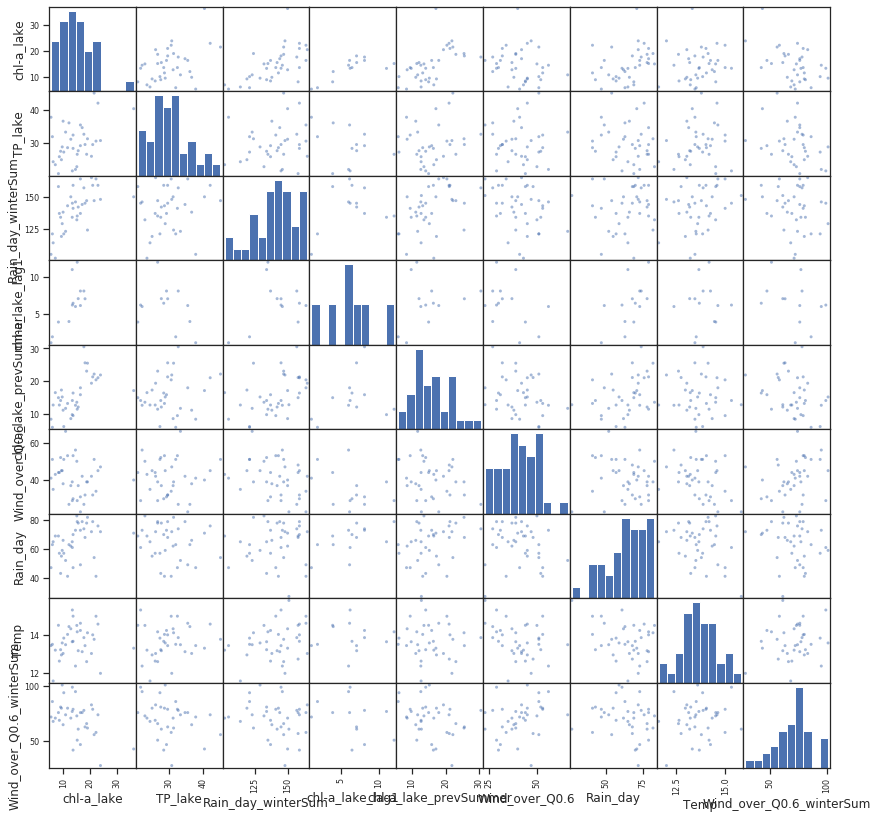

In [138]:
vars_for_scatterplot = ['chl-a_lake','TP_lake','Rain_day_winterSum',
                        'chl-a_lake_lag1','chl-a_lake_prevSummer','Wind_over_Q0.6','Rain_day',
                       'Temp','Wind_over_Q0.6_winterSum']

pd.plotting.scatter_matrix(season_df.loc[:,vars_for_scatterplot], figsize=(14,14));

plt.savefig(os.path.join(graph_outfolder,'seasonal_scattermatrix_chl-a_%s_%s.png'%(season_slice,basin)))

Previously, Jannicke Moe found an interaction between wind and temperature - with cyanobacteria blooms only when it was calm and warm. I think this was when she included within-year variability (which we're not doing here), but I will double-check for a temperature-wind interactive effect in between-year variability too. First just do this graphically by splitting the temperature into 'high' and 'low', and plotting chl-a vs wind, grouped by temperature class. Jannicke split the water temp into above and below 19 degrees C

In [139]:
# Regression tree to decide whether there's any reason for a temperature split

# For early summer:
# reg_df = season_df_lake_chla[['Temp', 'Wind_over_Q0.6_winterSum','chl-a_lake']].dropna()
# feature_cols = ['Temp', 'Wind_over_Q0.6_winterSum']

# For late summer (autumn):
reg_df = season_df_lake_chla[['Temp', 'chl-a_lake']].dropna()
feature_cols = ['Temp']

X = reg_df[feature_cols] # Features
y = reg_df['chl-a_lake'] # Target variable

# create a regressor object 
regressor = DecisionTreeRegressor(random_state = 0)  
  
# fit the regressor with X and Y data 
regressor.fit(X, y) 

y_pred = regressor.predict(X) 

# Model Accuracy, how often is the classifier correct?
# print("Accuracy:",metrics.accuracy_score(y, y_pred))

# export the decision tree to a tree.dot file for visualizing the plot easily anywhere
# Note: this produces a .dot file, which can either be converted to a png using pydotplus (not installed on the hub at the mo),
# or visualized using http://www.webgraphviz.com/ by copying the data from the ‘tree.dot’ file.

from sklearn.tree import export_graphviz

export_graphviz(regressor, out_file ='tree.dot', 
               feature_names =feature_cols)  

From this, pick air temp threshold of 13.5 degrees for early summer, and split into high or low

In [140]:
def disc_temp(temp):
    if temp > 11.0: return 'warm' #13.5 for early summer, 11 for late summer
    else: return 'cold'
season_df_lake_chla['Temp_2cat'] = season_df_lake_chla['Temp'].map(disc_temp)
season_df_lake_chla[['Temp','Temp_2cat']].head()

# # Scatter plot again, but grouping by whether warm or cold
# g = sns.pairplot(season_df_lake_chla.loc[:,vars_for_scatterplot+['Temp_2cat']], hue="Temp_2cat");
# plt.savefig(os.path.join(graph_outfolder,'seasonal_scattermatrix_chl-a_%s_byTemp_%s.png'%(season_slice,basin)))

,Temp,Temp_2cat
Date,,
1980-07-31,14.449403,warm
1981-07-31,13.213264,warm
1982-07-31,13.452291,warm
1983-07-31,13.517998,warm
1984-07-31,13.845605,warm


### 3) Response var = cyanobacterial biovolume

In [141]:
# cols to drop:
cols_to_drop = [
 'Biovolume',
 'Biovolume_lag1',
 'PTI',
 'PTI_lag1',
 'Temp_subzero'
    ]

season_df_cyano = season_df.drop(cols_to_drop,axis=1)
print (len(season_df_cyano))

# Drop any rows where explanatory var value is a NaN
season_df_cyano.dropna(subset=['CyanoBiovol'], inplace=True)
print (len(season_df_cyano))

39
23


In [142]:
X = season_df_cyano.drop(['CyanoBiovol'],axis=1)
y = season_df_cyano['CyanoBiovol']
corr_df = X.corrwith(y)
corr_df.sort_values()

colour_lake_prevSummer      -0.582984
colour_lake                 -0.559062
colour_lake_lag1            -0.534624
Q_lag1                      -0.512412
Wind_over_Q0.6_winterSum    -0.414829
Wind_over_Q0.8_winterSum    -0.397481
Temp                        -0.369310
Q_winterSum                 -0.301154
Pptn_lag1                   -0.289096
Wind_speed_lag1             -0.263903
Pptn_intense_winterSum      -0.253404
Pptn_intense_lag1           -0.240241
Pptn_winterSum              -0.235053
Wind_over_Q0.6_lag1         -0.207416
Wind_over_Q0.8_lag1         -0.190803
Temp_lag1                   -0.111974
PET_winterSum               -0.085745
Wind_speed                  -0.068501
Wind_over_Q0.8              -0.061971
Pptn_intense                -0.058339
TP_catch_lag1               -0.046583
Pptn                        -0.046383
PET_lag1                    -0.025156
TP_lake_lag1                 0.002491
Q                            0.025571
Wind_over_Q0.6               0.029875
chl-a_lake_l

### Correlations in Van 2:

**All seasons together:**
Similar to monthly:
- Strong correlation with lake chl-a (CC 0.73)
- Strong correlation with previous season's cyano biovol (CC 0.59), weaker with previous summer's average cyanobiovol
- Strong colour effect: current and previous season's colour (-0.65, -0.58), and previous summer's (-0.55). These 3 are all correlated with one another. BUT, **correlation or causation**? Over the study period, colour went up and cyanobacteria went down, but perhaps because of entirely independently. **If light limitation were an issue, wouldn't we expect a relationship between colour and chl-a too?**

**Just early summer (May-July):**
Strongest CCs:
- chl-a_lake (0.81), and chl-a previous summer (0.49)
- spring cyanobiovol (0.67) and previous summer's (0.55)
- Lake colour: prevSummer (-0.58), current season (-0.56), spring (-0.53) (all 3 very correlated with one another)
- TP_lake_prevSummer (0.5)
- Wind under Q0.2 in current season (0.45), and in winter (0.42)

For first time have TP and wind coming in a way we might expect

**Just late summer (Aug-Oct):**
Strongest CCs:
- chl-a_lake (0.69)
- Lake colour, previous summer (-0.62), current season (-0.63)
- Lake TP conc (0.59)
- early summer cyanobiovol (0.56) and previous summer's (0.66)
- Wind: winter wind (under Q0.2, CC 0.54; under Q0.4, CC 0.47). Current season: mean wind speed (-0.48), calm wind days have lower CCs (0.35'ish)
- PET (current season: 0.46; winter sum: -0.55). Maybe this is ~temperature, but because it's a summed variable rather than a mean, it represents the temperature-growth effect better somehow?



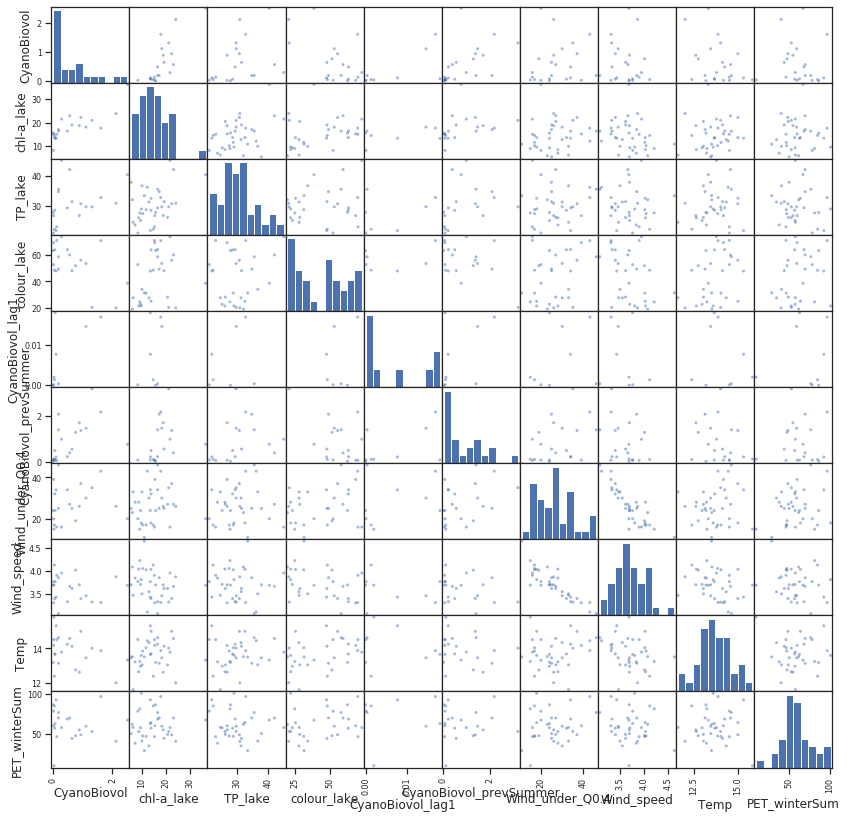

In [143]:
vars_for_scatterplot = ['CyanoBiovol','chl-a_lake','TP_lake','colour_lake',
                        'CyanoBiovol_lag1','CyanoBiovol_prevSummer','Wind_under_Q0.4','Wind_speed',
                       'Temp','PET_winterSum']

pd.plotting.scatter_matrix(season_df.loc[:,vars_for_scatterplot], figsize=(14,14));

plt.savefig(os.path.join(graph_outfolder,'seasonal_scattermatrix_cyano_%s_%s.png'%(season_slice,basin)))

As with chl-a, look for any interactions with temperature by splitting into low and high temperature groups

In [144]:
# Regression tree to decide whether there's any reason for a temperature split

# For early summer:
# reg_df = season_df_lake_chla[['Temp', 'Wind_over_Q0.6_winterSum','chl-a_lake']].dropna()
# feature_cols = ['Temp', 'Wind_over_Q0.6_winterSum']

# For late summer (autumn):
reg_df = season_df_cyano[['Temp', 'CyanoBiovol']].dropna()
feature_cols = ['Temp']

X = reg_df[feature_cols] # Features
y = reg_df['CyanoBiovol'] # Target variable

# create a regressor object 
regressor = DecisionTreeRegressor(random_state = 0)  
  
# fit the regressor with X and Y data 
regressor.fit(X, y) 

y_pred = regressor.predict(X) 

# Model Accuracy, how often is the classifier correct?
# print("Accuracy:",metrics.accuracy_score(y, y_pred))

# export the decision tree to a tree.dot file for visualizing the plot easily anywhere
# Note: this produces a .dot file, which can either be converted to a png using pydotplus (not installed on the hub at the mo),
# or visualized using http://www.webgraphviz.com/ by copying the data from the ‘tree.dot’ file.

from sklearn.tree import export_graphviz

export_graphviz(regressor, out_file ='tree.dot', 
               feature_names =feature_cols)  

From this, pick air temp threshold of 14 degrees for early summer, 11 in late summer, to split into high or low

/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


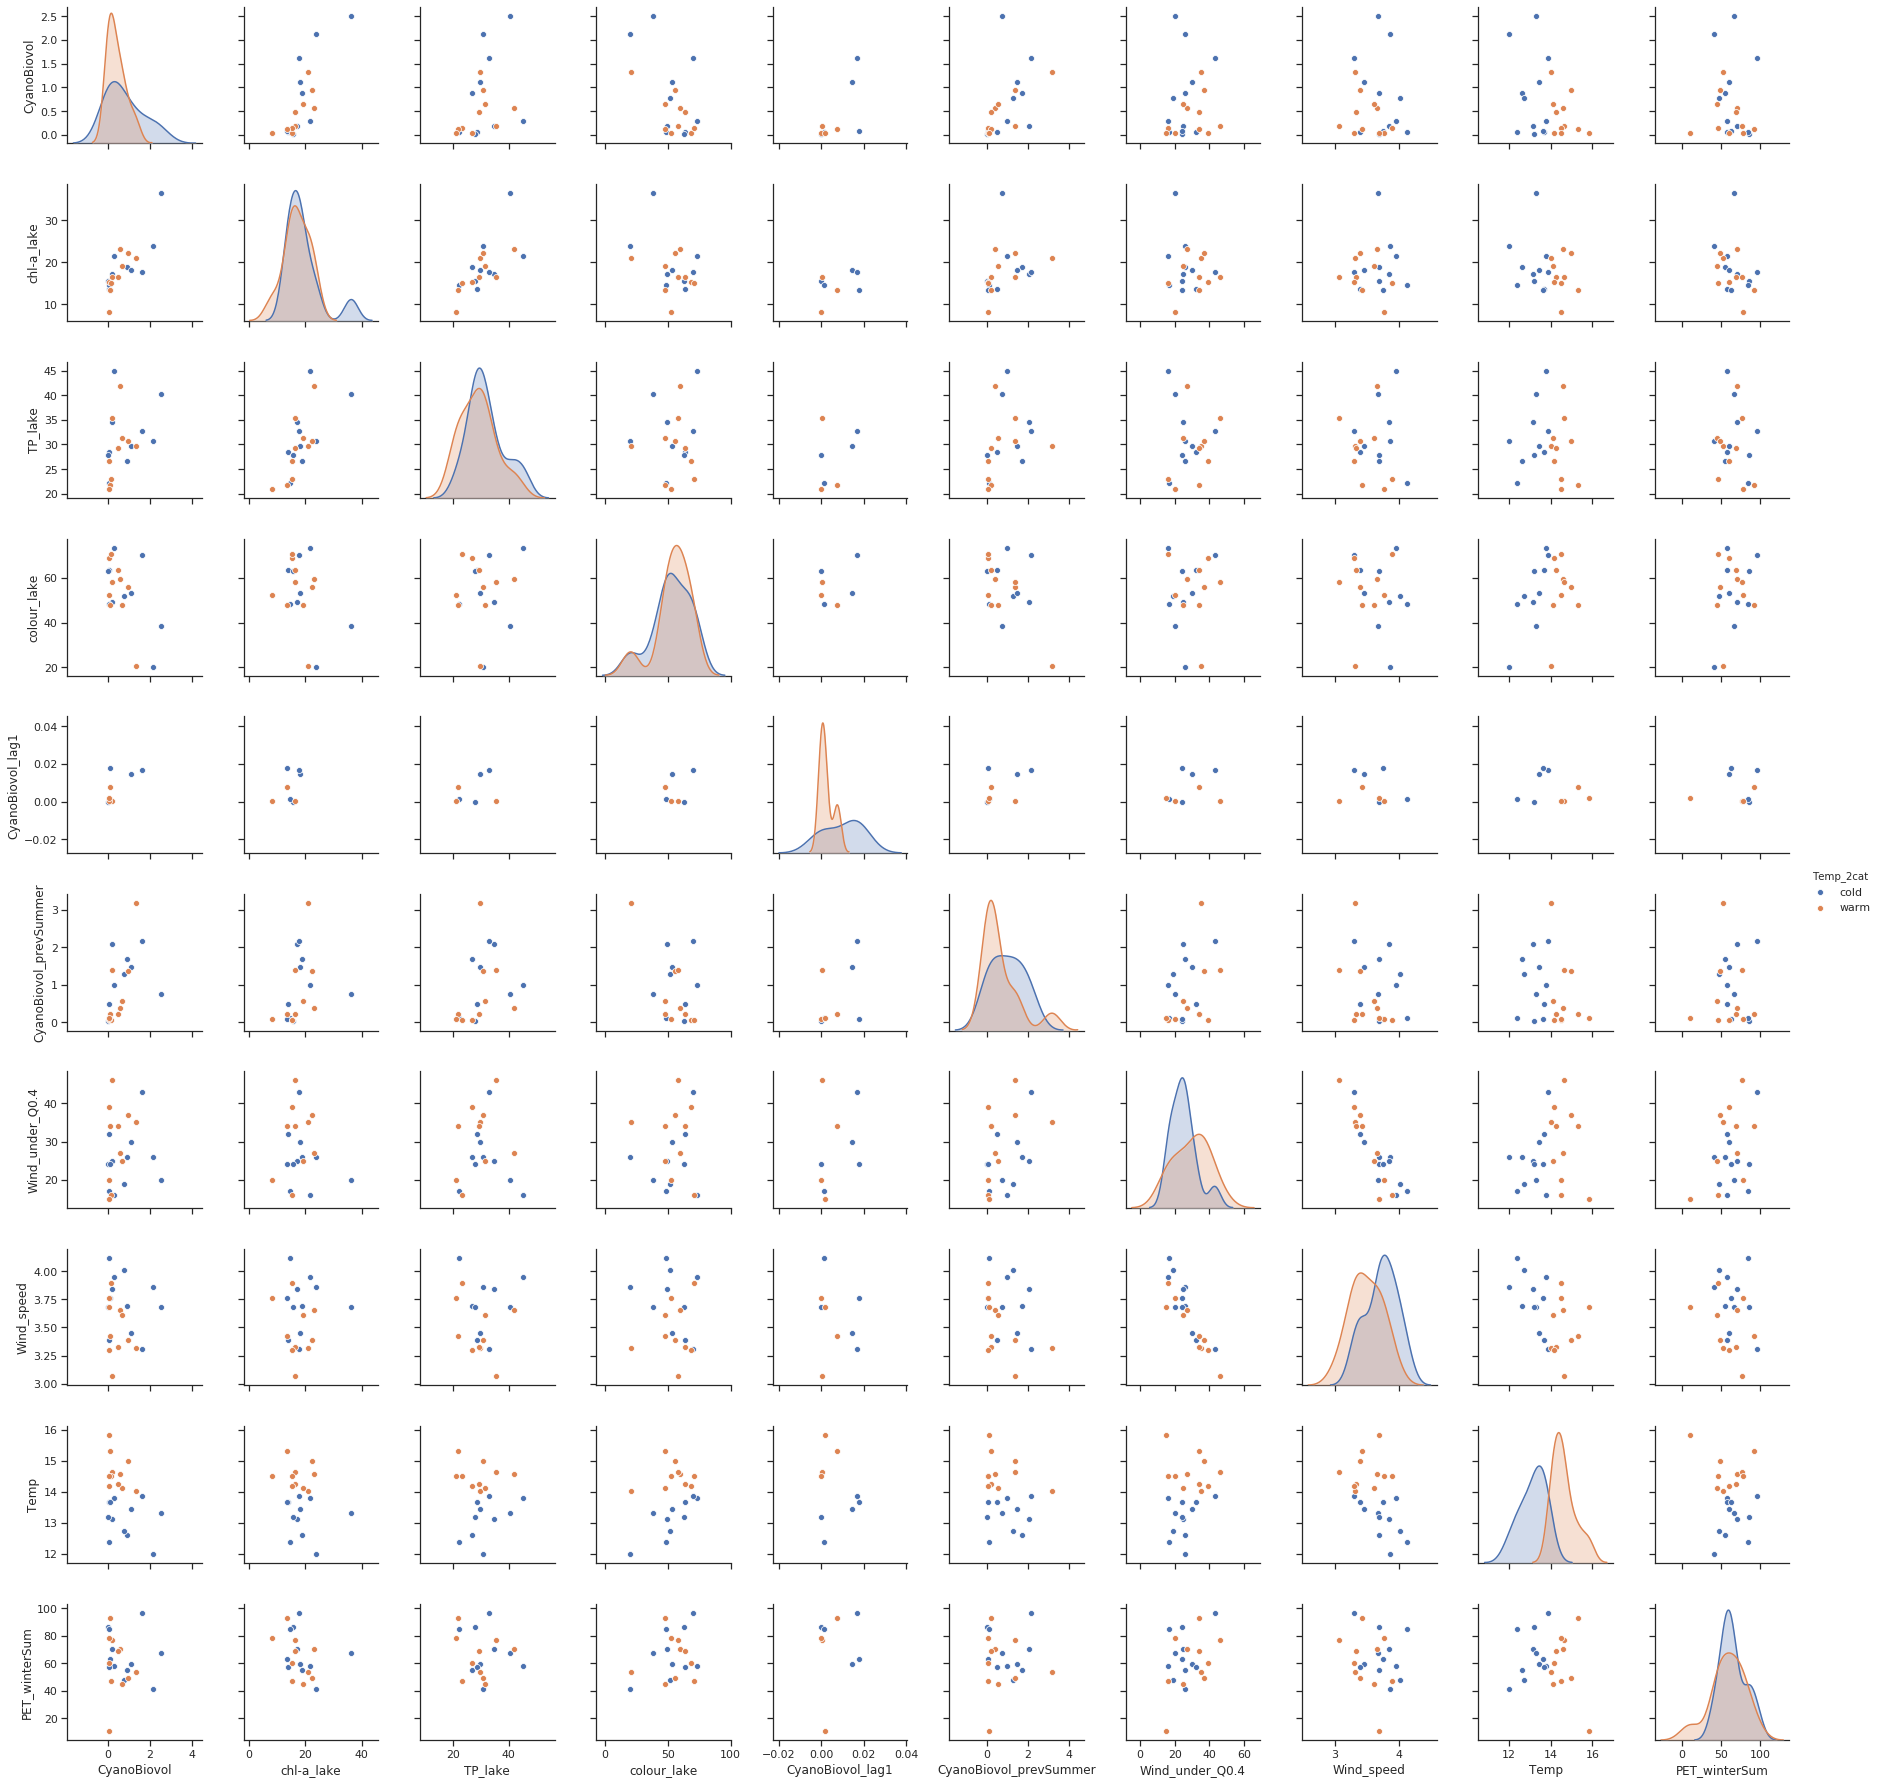

In [145]:
# def disc_temp(temp):
#     if temp > 14.0: return 'warm'
#     else: return 'cold'
# season_df_cyano['Temp_2cat'] = season_df_cyano['Temp'].map(disc_temp)
# season_df_cyano[['Temp','Temp_2cat']].head()

# # Scatter plot again, but grouping by whether warm or cold
# g = sns.pairplot(season_df_cyano.loc[:,vars_for_scatterplot+['Temp_2cat']], hue="Temp_2cat");
# plt.savefig(os.path.join(graph_outfolder,'seasonal_scattermatrix_cyano_%s_byTemp_%s.png'%(season_slice,basin)))

### 4) Response var = Lake colour

In [86]:
# Drop all ecological-related stuff

cols_to_drop = [
 'Biovolume',
 'Biovolume_lag1',
 'CyanoBiovol',
 'CyanoBiovol_lag1',
 'CyanoBiovol_prevSummer',
 'PTI',
 'PTI_lag1',
 'Season',
 'TP_catch',
 'TP_catch_lag1',
 'TP_lake',
 'TP_lake_lag1',
 'TP_lake_prevSummer',
 'chl-a_lake',
 'chl-a_lake_lag1',
 'chl-a_lake_prevSummer',
 'Temp_subzero'
    ]

season_df_lakeColour = season_df.drop(cols_to_drop,axis=1)
print (len(season_df_lakeColour))

# Drop any rows where response var is a NaN
season_df_lakeColour.dropna(subset=['colour_lake'], inplace=True)
print (len(season_df_lakeColour))
season_df_lakeColour.head()

155
99


,Pptn,Temp,Wind_speed,PET,Q,colour_lake,Rain_day,Pptn_intense,Wind_under_Q0.2,Wind_under_Q0.4,...,Rain_day_winterSum,Pptn_intense_winterSum,PET_winterSum,Q_winterSum,Temp_subzero_winterSum,Wind_under_Q0.2_winterSum,Wind_under_Q0.4_winterSum,Wind_over_Q0.6_winterSum,Wind_over_Q0.8_winterSum,colour_lake_prevSummer
Date,,,,,,,,,,,,,,,,,,,,,
1982-10-31,297.668159,10.870945,3.890217,204.064938,20262268.8,26.666667,77,16,11.0,28.0,...,105,14,50.619540,96553900.8,106.0,47.0,81.0,72.0,42.0,NaN
1983-04-30,122.882007,-0.047116,3.348315,46.470708,37266912.0,34.000000,47,3,20.0,36.0,...,121,18,62.161543,124071782.4,71.0,43.0,72.0,86.0,48.0,26.666667
1983-07-31,182.728817,13.517998,4.078261,320.759861,20778336.0,19.400000,63,7,5.0,23.0,...,121,18,62.161543,124071782.4,71.0,43.0,72.0,86.0,48.0,26.666667
1983-10-31,275.606690,10.877162,4.440217,202.271896,27490838.4,14.666667,57,13,8.0,25.0,...,121,18,62.161543,124071782.4,71.0,43.0,72.0,86.0,48.0,26.666667
1984-04-30,74.093285,-0.587583,3.718889,40.967914,39079065.6,28.000000,55,2,20.0,36.0,...,121,5,47.655810,73802188.8,107.0,36.0,65.0,94.0,58.0,17.033333


In [87]:
X = season_df_lakeColour.drop(['colour_lake'],axis=1)
y = season_df_lakeColour['colour_lake']
corr_df = X.corrwith(y)
corr_df.sort_values()

Temp                        -0.448365
PET                         -0.425872
Wind_over_Q0.6_lag1         -0.413877
Wind_speed_lag1             -0.400680
Wind_over_Q0.6              -0.272402
Wind_over_Q0.6_winterSum    -0.251519
Wind_speed                  -0.244770
PET_lag1                    -0.239275
Wind_over_Q0.8_winterSum    -0.214616
Wind_over_Q0.8_lag1         -0.205944
Temp_lag1                   -0.158958
Temp_subzero_winterSum      -0.124755
Wind_under_Q0.2_winterSum   -0.115827
Wind_over_Q0.8              -0.098510
Pptn                         0.064790
Pptn_intense                 0.071277
Temp_subzero_lag1            0.161435
Wind_under_Q0.4_winterSum    0.176624
Rain_day                     0.181658
Pptn_intense_winterSum       0.218342
Pptn_winterSum               0.220969
Wind_under_Q0.2              0.259770
Wind_under_Q0.4              0.260148
PET_winterSum                0.288979
Q_winterSum                  0.308056
Rain_day_winterSum           0.344136
Q_lag1      

### Lake colour correlations in Van 2, comments:

**All seasons:**
- Strong auto-correlation with lake colour the previous summer (0.77) and season (0.76)
- Delivery: Discharge sum current season (0.61), previous season (0.54) and during winter (0.53). Then rain-related features in previous season (CCs 0.53-0.48).
- Temperature and PET: -0.45, -0.43. i.e. warmer is lower colour. Just seasonal effect.

**Just early summer (May-July):**
Key things:
- Lake colour previous summer (0.85) and spring (0.87)
- Pptn (0.54)

**Late summer (Aug-Oct):**
- colour in early summer (0.87) and the previous summer (0.79)
- Rain things: Early summer precipitation (0.61) and intense precipitation (0.53)
- Current season's discharge (0.46)
All rest of CCs under 0.45



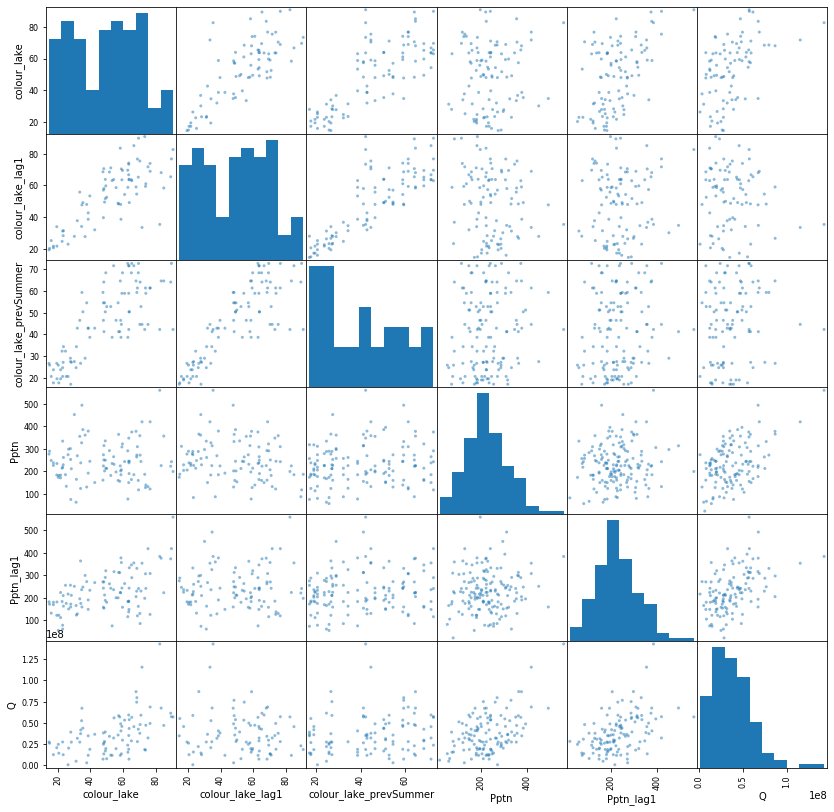

In [88]:
vars_for_scatterplot = ['colour_lake', 'colour_lake_lag1','colour_lake_prevSummer', 'Pptn',
                        'Pptn_lag1', 'Q']

pd.plotting.scatter_matrix(season_df.loc[:,vars_for_scatterplot], figsize=(14,14));

plt.savefig(os.path.join(graph_outfolder,'seasonal_scattermatrix_colour_%s_%s.png'%(season_slice,basin)))

# Write output csvs

In [89]:
# Save for the 'all' seasons slice, slicing then done in the feature selection (or other) notebooks

season_df_TP.to_csv(os.path.join(out_file,'dataMatrix_seasonal_TP_%s.csv'%basin), index_label='Date')
season_df_lake_chla.to_csv(os.path.join(out_file,'dataMatrix_seasonal_Chl-a_%s.csv'%basin), index_label='Date')
season_df_cyano.to_csv(os.path.join(out_file,'dataMatrix_seasonal_CyanoBiovol_%s.csv'%basin), index_label='Date')
season_df_lakeColour.to_csv(os.path.join(out_file,'dataMatrix_seasonal_colour_lake_%s.csv'%basin), index_label='Date')